<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_TRAJECTORY_embeddings_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 16.4 MB/s eta 0:00:00


In [2]:
import torch 
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


load nursing notes subject-caregiver-chartdate

In [4]:
import pandas as pd
import numpy as np
notes_path = "/content/drive/MyDrive/NIH/Data/"
notes_name = "NOTES_NURSING_TRAJECTORIES_01.csv"
df_notes = pd.read_csv(notes_path+notes_name)
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531675 entries, 0 to 531674
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ROW_ID      531675 non-null  int64 
 1   SUBJECT_ID  531675 non-null  int64 
 2   CGID        531675 non-null  int64 
 3   CHARTDATE   531675 non-null  object
 4   TEXT        531675 non-null  object
dtypes: int64(3), object(2)
memory usage: 20.3+ MB


lead from nicu (used in the previous work)

In [5]:
notes_name = "NOTES_NURSING_NEONATOLOGY.csv" # has young patient with matching notes
df_notes_neonat = pd.read_csv(notes_path+notes_name)
df_notes_neonat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SUBJECT_ID      1177 non-null   int64 
 1   CGID            1177 non-null   int64 
 2   ROW_ID          1177 non-null   int64 
 3   TEXT            1177 non-null   object
 4   text_num_words  1177 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 46.1+ KB


# **Data Preprocessing**

get from nicu

In [9]:
df_notes_nicu = pd.merge(df_notes,df_notes_neonat[['SUBJECT_ID','CGID']], how='inner', on=['SUBJECT_ID','CGID'])
df_notes_nicu.head()

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT
0,2080962,32392,17603,2199-12-05,NPN DAYS\nRECEIVED [**Doctor Last Name **] AT ...
1,2080962,32392,17603,2199-12-05,NPN DAYS\nRECEIVED [**Doctor Last Name **] AT ...
2,1816458,9864,17001,2196-06-07,NPN 7a-7p\n#1: Blood cultures remain negative ...
3,1816458,9864,17001,2196-06-07,NPN 7a-7p\n#1: Blood cultures remain negative ...
4,1816458,9864,17001,2196-06-07,NPN 7a-7p\n#1: Blood cultures remain negative ...


## Data exploration 

check number of notes per patient/subject

number of notes: min=1, max=255, mean=10.216019417475728,  median=2.0


<Axes: xlabel='TEXT'>

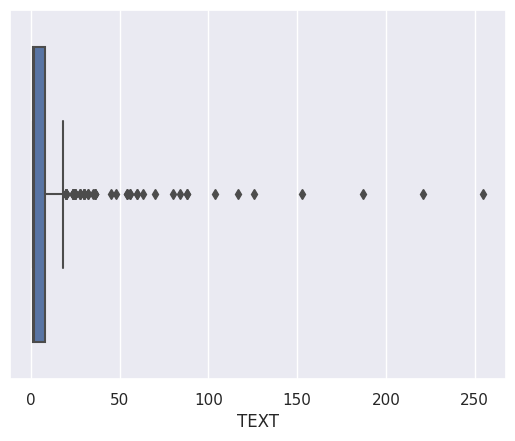

In [23]:
import seaborn as sns
sns.set()


gb_notes = df_notes_nicu.groupby(['CGID','SUBJECT_ID'])
num_notes = gb_notes['TEXT'].count()

print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()},  median={num_notes.median()}')
sns.boxplot(x=num_notes)

check number of caregiver/subject that have between 4 and 15 notes

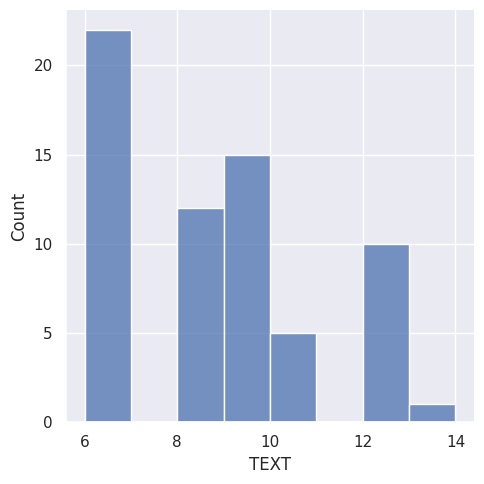

In [12]:
sns.displot(num_notes[((num_notes>4) & (num_notes<15))])

take only caregivers/patients' ids that have 6 notes (to start)

In [24]:
ids = num_notes[num_notes==6].index

MultiIndex([(14274, 21063),
            (14282,  3071),
            (14282, 25499),
            (14295,  4412),
            (14489, 10582),
            (14489, 18093),
            (14712, 14339),
            (14872,  8301),
            (14872, 30406),
            (14989,  4412),
            (14989,  7962),
            (16024, 25845),
            (16523, 20002),
            (17858,  2402),
            (18249, 23286),
            (18255, 14339),
            (18785,  2181),
            (18785,  3071),
            (18785, 14339),
            (19591,  5757),
            (20104, 30406),
            (20634,  7919)],
           names=['CGID', 'SUBJECT_ID'])

In [26]:
sentences = df_notes[ (df_notes['CGID'] == 14274) & (df_notes['SUBJECT_ID'] == 21063) ]['TEXT'].to_list()
for sentence in sentences:
  print(sentence)
  print('\n\n\n')



Nursing Progress Note


#1-O/A-  Cont on Amp/Gent for r/o sepsis.  Plans for repeat
CBC this eve.  Bl cx pending.  No current signs of
infection.  P- Cont to assess for s/s of infection.
#2-O/A-  TF increased to 160cc/kg/d for Na=151, K=6.9,
Cl=118.  Currently UAC with 1/2NS w/ 1/2u hep/cc.  DLUVC
with D5W w/  1/2u hep/cc through both lines.  Dopamine
30mg/50ccD5W piggy back into 2nd line.  Abd soft/flat, BS
not audible so far this shift.  Glucose=83,89.  Voiding qs,
no stool so far this shift.  Plans to send urine for u/a.
Plans to check lytes with BUN, Cr later this shift.  P-
Cont to assess for FEN needs.
#3-O/A-  [**Known lastname 722**] cont to sleep between cares.  Occasional
activity between cares.  Jittery with touch during cares.
Temp stable on warmer with temp.  Becomes unstable when tent
is removed.  Infant is nested on sheepskin with blanket and
gel cushion.  P-  Cont to assess for G&D needs.
#4-O/A-  Received infant vented at 18/5 with rate of 18.
Infant weaned for good ga

In [ ]:
# filter cgid and subjectid pairs to contain between a certain number of notes

#print(df_notes['CGID'].unique())
new_df = df_notes.groupby(['CGID','SUBJECT_ID'])['TEXT'].count()
new_df = new_df.reset_index()
new_df = new_df.rename(columns={'TEXT':'COUNT'})
df_filtered = new_df.loc[ (new_df['COUNT'] > 5) & (new_df['COUNT'] < 9) ].reset_index()
print(df_filtered)

     index   CGID  SUBJECT_ID  COUNT
0      156  14151       40577      8
1      159  14151       41034      6
2      204  14151       58928      6
3      223  14151       67529      8
4      262  14151       78518      7
..     ...    ...         ...    ...
553  41496  21452        1709      7
554  41537  21452       31942      8
555  41564  21452       50859      7
556  41608  21452       70516      8
557  41671  21452       94698      8

[558 rows x 4 columns]


In [ ]:
# loop through entire list of caregiver and subject pairs

# loop with groupby
#for Cg_Subject_Pair in group_keys:
  #df_notes[ (df_notes['CGID'] == Cg_Subject_Pair[0]) & (df_notes['SUBJECT_ID'] == Cg_Subject_Pair[1]) ]['TEXT'].to_list()
  #print(Cg_Subject_Pair[0],Cg_Subject_Pair[1])

# loop with dataframe
for Cg_Subject_Pair in df_filtered.iterrows():
  print(f"CGID:{Cg_Subject_Pair[1]['CGID']} SUBID:{Cg_Subject_Pair[1]['SUBJECT_ID']}")
  df_notes[ (df_notes['CGID'] == Cg_Subject_Pair[1]['CGID']) & (df_notes['SUBJECT_ID'] == Cg_Subject_Pair[1]['SUBJECT_ID']) ]['TEXT'].to_list()


CGID:14151 SUBID:40577
CGID:14151 SUBID:41034
CGID:14151 SUBID:58928
CGID:14151 SUBID:67529
CGID:14151 SUBID:78518
CGID:14182 SUBID:30829
CGID:14214 SUBID:10774
CGID:14214 SUBID:64798
CGID:14214 SUBID:80274
CGID:14214 SUBID:84461
CGID:14228 SUBID:54247
CGID:14228 SUBID:56854
CGID:14228 SUBID:76222
CGID:14228 SUBID:89062
CGID:14357 SUBID:70516
CGID:14357 SUBID:87743
CGID:14357 SUBID:98593
CGID:14411 SUBID:27427
CGID:14411 SUBID:27472
CGID:14411 SUBID:30139
CGID:14411 SUBID:66508
CGID:14411 SUBID:80927
CGID:14411 SUBID:90538
CGID:14419 SUBID:18333
CGID:14419 SUBID:29765
CGID:14419 SUBID:59832
CGID:14419 SUBID:99491
CGID:14427 SUBID:78076
CGID:14427 SUBID:97542
CGID:14431 SUBID:31290
CGID:14431 SUBID:61213
CGID:14431 SUBID:94202
CGID:14435 SUBID:40577
CGID:14435 SUBID:51839
CGID:14435 SUBID:83570
CGID:14442 SUBID:28533
CGID:14442 SUBID:32414
CGID:14518 SUBID:58662
CGID:14518 SUBID:74835
CGID:14542 SUBID:49358
CGID:14542 SUBID:77560
CGID:14576 SUBID:46656
CGID:14576 SUBID:50454
CGID:14576 

## Embeddings 

In [ ]:
model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [ ]:
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
  model_output = model(**encoded_input)

for k,v in encoded_input.items():
  print(k)
  print(v.numpy())

input_ids
[[  101  4720  2095 ... 11888  3255   102]
 [  101  4720  2095 ...  3456  2058   102]
 [  101  9016  1010 ...     0     0     0]
 ...
 [  101  2824  1024 ...     0     0     0]
 [  101  2516  1024 ...     0     0     0]
 [  101 10089  7667 ...     0     0     0]]
token_type_ids
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
attention_mask
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [ ]:
token_embeddings = model_output.last_hidden_state
print(token_embeddings.size())
print('num of sentences, num of tokens, embed dim')
print('ONE EMBEDDING VECTOR PER TOKEN')

torch.Size([8, 512, 384])
num of sentences, num of tokens, embed dim
ONE EMBEDDING VECTOR PER TOKEN


In [ ]:
def mean_pooling(model_output, attention_mask):
  token_embeddings = model_output.last_hidden_state
  input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
  return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)
print('ONE EMBEDDING VECTOR PER SENTENCE')

Sentence embeddings:
tensor([[-0.0394, -0.0165,  0.0390,  ..., -0.0023, -0.0041,  0.0138],
        [-0.0274, -0.0235,  0.0126,  ..., -0.0115, -0.0093,  0.0223],
        [-0.0179,  0.0127, -0.0381,  ..., -0.0345, -0.0261, -0.0044],
        ...,
        [-0.0352, -0.0391, -0.0051,  ..., -0.0909,  0.0171,  0.0098],
        [-0.0299, -0.0047, -0.0345,  ..., -0.0693, -0.0741,  0.0214],
        [-0.0243, -0.0256, -0.0032,  ..., -0.0181, -0.0996,  0.0161]])
ONE EMBEDDING VECTOR PER SENTENCE


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

sentence_embeddings_np = sentence_embeddings.detach().numpy()

scores = np.zeros((sentence_embeddings_np.shape[0],sentence_embeddings_np.shape[0]))
dist = []
for idx in range(sentence_embeddings_np.shape[0]):
  scores[idx,:] = cosine_similarity([sentence_embeddings_np[idx]],sentence_embeddings_np)[0]            
  if idx < len(sentence_embeddings_np)-1:
    dist.append(scores[idx,idx+1])

scores     

array([[0.99999988, 0.92559719, 0.65373111, 0.62693524, 0.67897218,
        0.63586247, 0.62395692, 0.5566029 ],
       [0.92559719, 0.99999988, 0.64192617, 0.61476386, 0.60430825,
        0.60875779, 0.53871596, 0.47071207],
       [0.65373111, 0.64192617, 1.00000012, 0.96904504, 0.76145911,
        0.72633278, 0.75415707, 0.59435105],
       [0.62693524, 0.61476386, 0.96904504, 1.00000012, 0.75251949,
        0.73662257, 0.74104422, 0.5781253 ],
       [0.67897218, 0.60430825, 0.76145911, 0.75251949, 1.00000024,
        0.72554851, 0.78717375, 0.68833739],
       [0.63586247, 0.60875779, 0.72633278, 0.73662257, 0.72554851,
        1.00000012, 0.68371177, 0.62954491],
       [0.62395692, 0.53871596, 0.75415707, 0.74104422, 0.78717375,
        0.68371177, 0.99999988, 0.67332351],
       [0.5566029 , 0.47071207, 0.59435105, 0.5781253 , 0.68833739,
        0.62954491, 0.67332351, 1.        ]])

<Axes: >

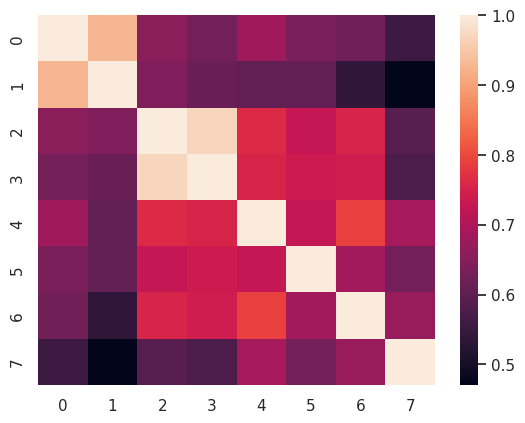

In [ ]:
import seaborn as sns
sns.set()

sns.heatmap(scores)

<Axes: >

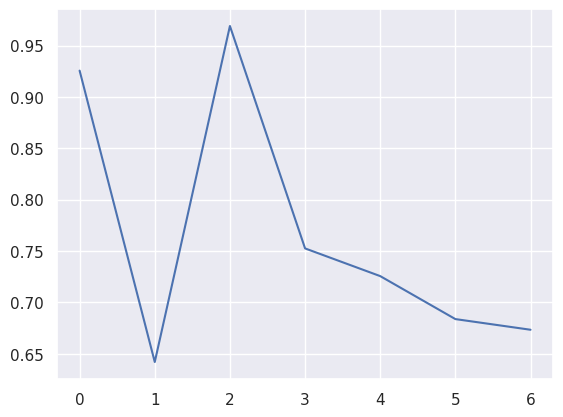

In [ ]:
sns.lineplot(dist)

## Clustering 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [ ]:
clustering_model = KMeans(n_clusters=3)
clustering_model.fit(sentence_embeddings_np)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

[0 0 1 1 1 1 1 2]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(sentences[sentence_id])
clustered_sentences

{0: ['52 year old male sp motorcycle crash at estimated 70 mph. Intubated\n   prior to arrival, hypotensive and bradycardic in ED. Resuscitated with\n   large volume crystalloid and PRBCs and directly to OR. Pt has extensive\n   PMHx including significant cardiac disease and CRI with baseline\n   creatinine of 2.0.\n   Injuries include:\n   (1)     Bil Elbow fractures with extensive degloving injuries.\n   (2)     R Knee degloving\n   (3)     Large R groin laceration-no vessels involved.\n   (4)     Larceration to L side of nose with abrasions.\n   (5)     Abdominal abrasions and incision with fascia closed and dermis\n   left open\n   Procedures;\n           (1) [**11-8**] to OR from ED for Abdominal ex-lap +for blood in\n   abdomen without visible source, dermis left open with exposed lap band\n   port. BUEs exploration and wash-out   with bilaterally VAC dressings.\n   Exploration and wash out of L groin wound with w-d packing. Transiently\n   requiring pressors, cont blood products

In [ ]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 8)
X = sentence_embeddings_np 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'cosine'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

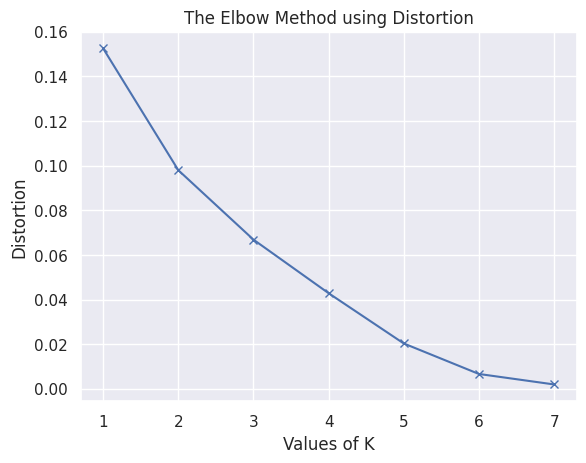

In [ ]:
import matplotlib.pyplot as plt
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()